In [2]:
%env CUDA_VISIBLE_DEVICES=0
!nvidia-smi
import torch
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("GPU count:", torch.cuda.device_count())
if torch.cuda.is_available():
  print("GPU #0:", torch.cuda.get_device_name(0))

env: CUDA_VISIBLE_DEVICES=0


Mon May 12 12:15:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.133.20             Driver Version: 570.133.20     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   76C    P0             36W /   72W |    1732MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
# Cell 1 — Setup & imports
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from models import UNET, SinusoidalEmbeddings, ResBlock
from train import train
from inference import inference, display_reverse
from attention import Attention
from diffusion.sampler import DDPM_Scheduler    


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [2]:
!uv add torchvision
!uv add timm

Resolved 240 packages in 10ms
Audited 230 packages in 0.31ms
Resolved 240 packages in 10ms
Audited 230 packages in 0.19ms


In [3]:
train_dataset = datasets.MNIST(root='./Data', train=True, download=False,transform=transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True, num_workers=4)

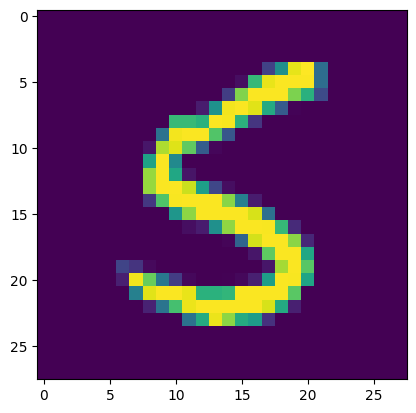

In [4]:
batch = next(iter(train_loader))
x, y = batch

import matplotlib.pyplot as plt

plt.imshow(x[0].squeeze(0).numpy())
plt.show()

In [5]:
print("x.shape", x.shape)
print("y.shape", y.shape)

x.shape torch.Size([16, 1, 28, 28])
y.shape torch.Size([16])


In [6]:
x.shape[0]

16

In [28]:
scheduler = DDPM_Scheduler().to(device)

In [8]:
# Cell 2 — Inspect your network shapes & param counts
# Instantiate a toy input
B, C, H, W = 16, 1, 32, 32
# Dummy timesteps
t = torch.randint(0, 1000, (B,), device=device)
x = x.to(device)      # e.g. [B,1,32,32] float32 on GPU
t  = t.to()  

In [9]:
# Shapes
print("β shape:", scheduler.beta.shape)
print("ᾱ shape:", scheduler.alpha.shape)

β shape: torch.Size([1000])
ᾱ shape: torch.Size([1000])


In [10]:
print("β[0], β[-1]:", scheduler.beta[0].item(), scheduler.beta[-1].item())
print("ᾱ[0], ᾱ[-1]:", scheduler.alpha[0].item(), scheduler.alpha[-1].item())

β[0], β[-1]: 9.999999747378752e-05 0.019999999552965164
ᾱ[0], ᾱ[-1]: 0.9998999834060669 4.035830352222547e-05


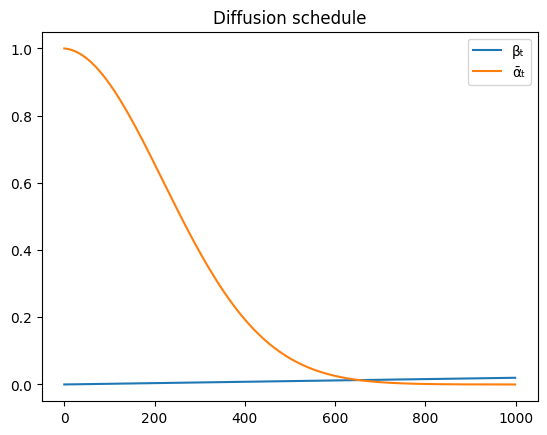

In [11]:
import matplotlib.pyplot as plt
plt.plot(scheduler.beta.cpu().numpy(), label="βₜ")
plt.plot(scheduler.alpha.cpu().numpy(), label="ᾱₜ")
#    plt.yscale("log")
plt.legend(); plt.title("Diffusion schedule"); plt.show()

In [12]:
net = UNET().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=2e-5)
x = F.pad(x, (2,2,2,2))
# output = net(x, t)

In [13]:
import math
torch.arange(0, 10, 1).float()  * -(math.log(10000.0) / 10)

tensor([-0.0000, -0.9210, -1.8421, -2.7631, -3.6841, -4.6052, -5.5262, -6.4472,
        -7.3683, -8.2893])

In [14]:
t = torch.randint(0, 1000, (B,), device=device)

In [15]:
e = torch.randn_like(x) 

In [16]:
e.mean(), e.std(), e.shape

(tensor(-0.0107, device='cuda:0'),
 tensor(0.9964, device='cuda:0'),
 torch.Size([16, 1, 32, 32]))

In [30]:
a = scheduler.alpha_cumprod[t]
a

tensor([8.2606e-01, 8.2834e-01, 3.4508e-01, 8.5966e-04, 5.1611e-01, 1.5841e-01,
        9.1326e-01, 1.1230e-03, 8.0037e-01, 9.3505e-04, 9.0073e-01, 6.4016e-01,
        9.8065e-01, 8.4618e-01, 1.1904e-02, 7.4336e-01], device='cuda:0')

In [22]:
t

tensor([133, 132, 321, 834, 252, 424,  90, 818, 144, 829,  97, 206,  39, 124,
        660, 167], device='cuda:0')

In [24]:
scheduler.beta[t]

tensor([0.0027, 0.0027, 0.0065, 0.0167, 0.0051, 0.0085, 0.0019, 0.0164, 0.0030,
        0.0166, 0.0020, 0.0042, 0.0009, 0.0026, 0.0132, 0.0034],
       device='cuda:0')

In [31]:
scheduler.alpha.shape

torch.Size([1000])

In [32]:
a = scheduler.alpha_cumprod[t].view(B, 1, 1, 1)

In [34]:
a.shape

torch.Size([16, 1, 1, 1])

In [38]:
x_t.shape

torch.Size([16, 1, 32, 32])

In [45]:
1 - a.view(-1) ** 0.5

tensor([0.0911, 0.0899, 0.4126, 0.9707, 0.2816, 0.6020, 0.0444, 0.9665, 0.1054,
        0.9694, 0.0509, 0.1999, 0.0097, 0.0801, 0.8909, 0.1378],
       device='cuda:0')

In [49]:
(torch.sqrt(1-a)*e).shape

torch.Size([16, 1, 32, 32])

In [46]:
a.view(-1) ** 0.5

tensor([0.9089, 0.9101, 0.5874, 0.0293, 0.7184, 0.3980, 0.9556, 0.0335, 0.8946,
        0.0306, 0.9491, 0.8001, 0.9903, 0.9199, 0.1091, 0.8622],
       device='cuda:0')

In [35]:
x_t   = torch.sqrt(a)*x + torch.sqrt(1-a)*e     

In [37]:
x_t.shape

torch.Size([16, 1, 32, 32])

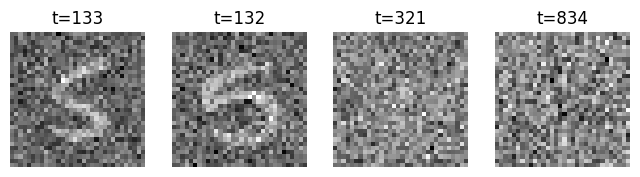

In [36]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,4, figsize=(8,2))
for i,ax in enumerate(axs):
    ax.imshow(x_t[i,0].cpu(), cmap='gray')
    ax.set_title(f't={t[i].item()}')
    ax.axis('off')
plt.show()

In [50]:
pred = net(x_t, t)
pred.shape

torch.Size([16, 1, 32, 32])

In [52]:
loss = F.mse_loss(pred, e)

In [53]:
print('MSE loss:', loss.item())

MSE loss: 1.0480709075927734


In [ ]:
optimizer.zero_grad()
loss.backward()
optimizer.step()
